In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex

import sys
sys.path.insert(0, '/content/drive/MyDrive/Step5Gabri')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from copy import deepcopy
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction, decode_segmap
from Cityscapes import Cityscapes
from bisenetv2 import BiSeNetV2
from selftrainloss import SelfTrainingLoss
from server import Server
from client import Client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 30.2 MB/s eta 0:00:00


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 4       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 8       # Total number of training epochs (iterations over dataset)
NUM_ROUNDS = 8
NUM_CLIENTS = 10
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 512
RESIZED_W = 1024

MODEL_PATH = '/content/drive/MyDrive/Step5Gabri/step4_FDA_partB_L0.01.tar' #Model to be loaded

Running on cuda


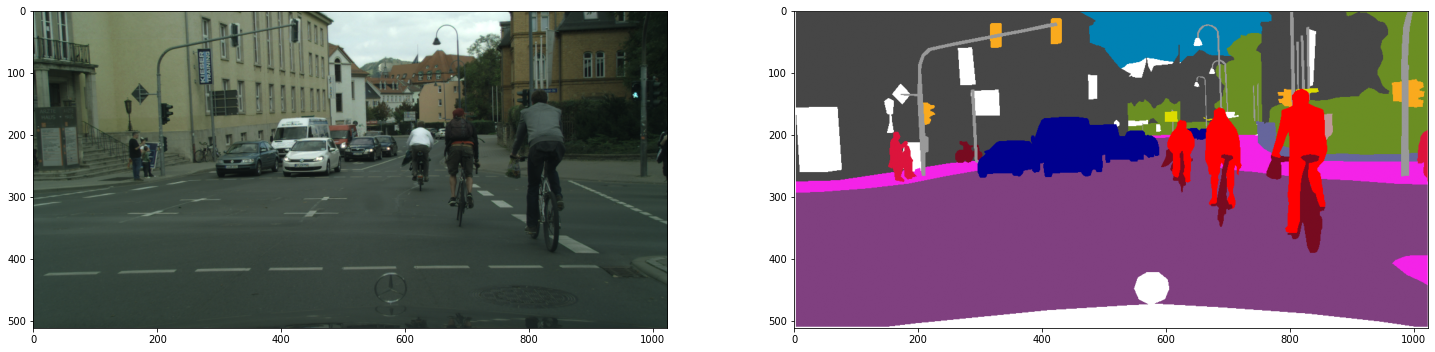

In [4]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]
normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])

train_dataset = Cityscapes('drive/MyDrive/', partition_type=('A', 'uniform'), split='train', transform=train_transform, target_transform=target_transform)
test_dataset = Cityscapes('drive/MyDrive/', partition_type=('A', 'uniform'), split='val', transform=eval_transform, target_transform=target_transform)

i, l = test_dataset.__getitem__(1)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
l = decode_segmap(l.squeeze())
plt.imshow(l)
plt.show()

In [5]:
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Number of clients: 36
Loading pre-trained model, mIoU=0.1744311898946762
Client #32: 0.015 0.032 0.051 0.066 0.077 0.078 0.090 0.093 
Client #21: 0.016 0.038 0.061 0.068 0.070 0.072 0.078 0.079 
Client #17: 0.017 0.040 0.062 0.069 0.077 0.078 0.079 0.082 
Client #31: 0.016 0.028 0.048 0.062 0.074 0.073 0.084 0.091 
Client #23: 0.017 0.034 0.050 0.062 0.068 0.070 0.074 0.080 
Client #16: 0.016 0.032 0.046 0.058 0.064 0.069 0.070 0.073 
Client #11: 0.018 0.040 0.065 0.074 0.075 0.081 0.081 0.091 
Client #3: 0.016 0.038 0.063 0.074 0.079 0.091 0.093 0.104 
Client #12: 0.017 0.039 0.062 0.075 0.079 0.085 0.090 0.092 
Client #30: 0.014 0.027 0.045 0.057 0.066 0.072 0.077 0.080 
ROUND 1: server mIoU = 0.014


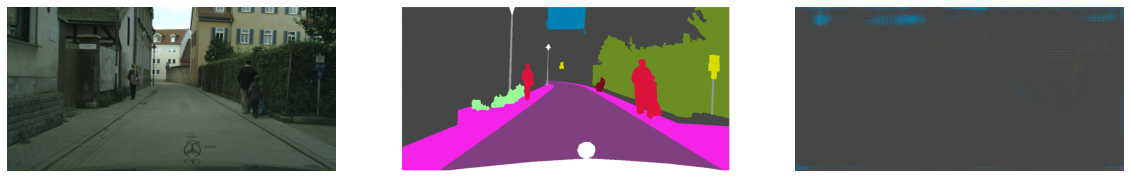

Client #31: 0.151 0.147 0.167 0.158 0.156 0.168 0.171 0.166 
Client #35: 0.158 0.175 0.175 0.192 0.185 0.179 0.184 0.186 
Client #29: 0.134 0.138 0.152 0.157 0.150 0.149 0.152 0.152 
Client #4: 0.132 0.143 0.150 0.150 0.151 0.151 0.154 0.152 
Client #20: 0.146 0.157 0.174 0.177 0.169 0.182 0.171 0.174 
Client #18: 0.142 0.151 0.161 0.160 0.154 0.163 0.158 0.161 
Client #22: 0.142 0.154 0.162 0.156 0.157 0.158 0.160 0.160 
Client #24: 0.135 0.141 0.154 0.145 0.157 0.151 0.152 0.151 
Client #30: 0.137 0.144 0.163 0.152 0.158 0.157 0.156 0.157 
Client #27: 0.131 0.142 0.157 0.154 0.157 0.149 0.167 0.151 
ROUND 2: server mIoU = 0.147


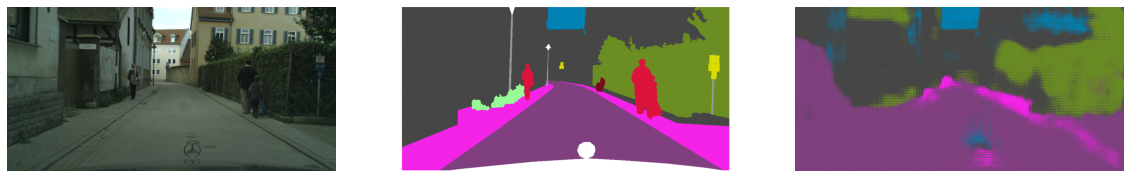

Client #13: 0.144 0.136 0.145 0.135 0.143 0.147 0.143 0.145 
Client #14: 0.142 0.140 0.143 0.138 0.140 0.139 0.137 0.143 
Client #29: 0.152 0.142 0.153 0.146 0.148 0.151 0.149 0.149 
Client #31: 0.162 0.154 0.163 0.166 0.160 0.163 0.168 0.166 
Client #25: 0.144 0.133 0.144 0.147 0.144 0.146 0.141 0.149 
Client #10: 0.149 0.154 0.156 0.154 0.157 0.157 0.157 0.155 
Client #28: 0.150 0.135 0.153 0.138 0.147 0.147 0.147 0.149 
Client #1: 0.153 0.151 0.157 0.155 0.156 0.157 0.153 0.159 
Client #26: 0.154 0.147 0.153 0.151 0.150 0.152 0.152 0.153 
Client #15: 0.152 0.156 0.166 0.156 0.165 0.167 0.166 0.164 
ROUND 3: server mIoU = 0.126


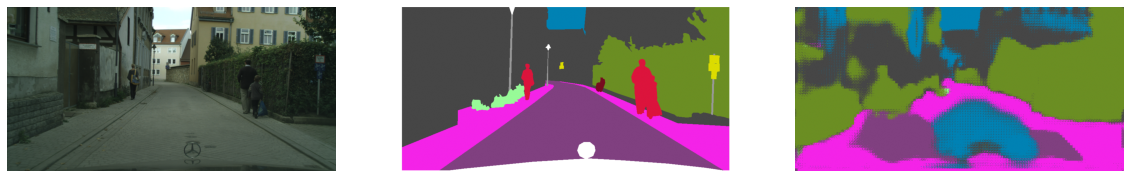

Client #5: 0.163 0.164 0.160 0.163 0.164 0.163 0.165 0.163 
Client #27: 0.161 0.151 0.154 0.154 0.156 0.155 0.155 0.156 
Client #19: 0.161 0.150 0.155 0.153 0.155 0.153 0.157 0.156 
Client #23: 0.157 0.151 0.149 0.150 0.147 0.152 0.147 0.152 
Client #18: 0.163 0.151 0.158 0.157 0.157 0.157 0.159 0.157 
Client #24: 0.150 0.148 0.149 0.147 0.148 0.148 0.148 0.149 
Client #16: 0.147 0.140 0.144 0.142 0.141 0.143 0.146 0.146 
Client #28: 0.153 0.137 0.151 0.141 0.143 0.149 0.146 0.147 
Client #14: 0.145 0.141 0.139 0.141 0.141 0.139 0.142 0.140 
Client #34: 0.177 0.157 0.169 0.169 0.166 0.168 0.169 0.168 
ROUND 4: server mIoU = 0.133


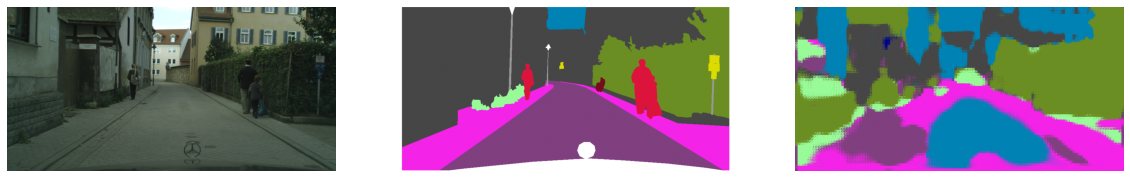

Client #16: 0.149 0.142 0.145 0.149 0.143 0.148 0.146 0.141 
Client #23: 0.151 0.144 0.153 0.146 0.150 0.152 0.144 0.152 
Client #18: 0.158 0.155 0.158 0.156 0.156 0.157 0.157 0.157 
Client #21: 0.158 0.152 0.153 0.157 0.158 0.156 0.156 0.158 
Client #35: 0.173 0.180 0.178 0.181 0.182 0.181 0.180 0.180 
Client #17: 0.151 0.150 0.153 0.150 0.153 0.152 0.151 0.155 
Client #30: 0.157 0.158 0.156 0.154 0.156 0.156 0.156 0.156 
Client #22: 0.158 0.154 0.156 0.155 0.157 0.156 0.157 0.157 
Client #3: 0.184 0.182 0.184 0.183 0.182 0.185 0.185 0.184 
Client #25: 0.143 0.140 0.142 0.147 0.141 0.146 0.145 0.143 
ROUND 5: server mIoU = 0.125


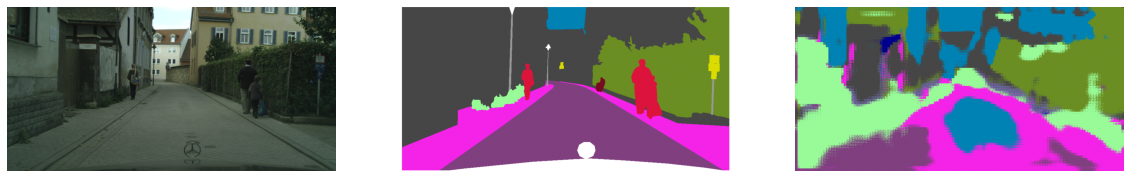

Client #32: 0.167 0.175 0.170 0.176 0.172 0.171 0.178 0.175 
Client #23: 0.142 0.148 0.145 0.150 0.143 0.150 0.150 0.149 
Client #4: 0.140 0.148 0.146 0.148 0.148 0.149 0.149 0.149 
Client #19: 0.153 0.156 0.157 0.157 0.154 0.159 0.160 0.159 
Client #21: 0.155 0.151 0.157 0.154 0.158 0.154 0.157 0.154 
Client #6: 0.149 0.149 0.151 0.153 0.153 0.156 0.157 0.156 
Client #1: 0.151 0.155 0.157 0.153 0.161 0.154 0.156 0.157 
Client #20: 0.168 0.165 0.178 0.170 0.174 0.172 0.174 0.174 
Client #24: 0.143 0.144 0.152 0.149 0.150 0.147 0.149 0.147 
Client #11: 0.174 0.171 0.178 0.176 0.179 0.176 0.179 0.177 
ROUND 6: server mIoU = 0.153


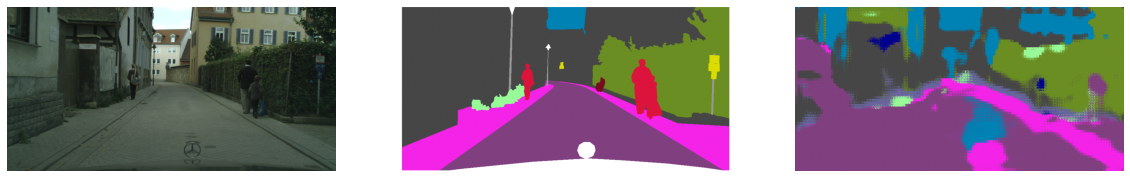

Client #19: 0.152 0.156 0.160 0.158 0.157 0.159 0.159 0.159 
Client #8: 0.143 0.142 0.146 0.140 0.152 0.141 0.146 0.145 
Client #25: 0.140 0.142 0.145 0.140 0.148 0.146 0.146 0.147 
Client #1: 0.152 0.157 0.157 0.153 0.163 0.152 0.159 0.154 
Client #20: 0.169 0.167 0.177 0.174 0.177 0.174 0.174 0.174 
Client #22: 0.153 0.155 0.155 0.157 0.156 0.156 0.156 0.155 
Client #31: 0.160 0.164 0.167 0.163 0.161 0.164 0.165 0.165 
Client #4: 0.142 0.149 0.149 0.148 0.148 0.150 0.149 0.149 
Client #27: 0.150 0.154 0.155 0.157 0.156 0.157 0.156 0.157 
Client #7: 0.166 0.177 0.168 0.177 0.166 0.175 0.173 0.172 
ROUND 7: server mIoU = 0.165


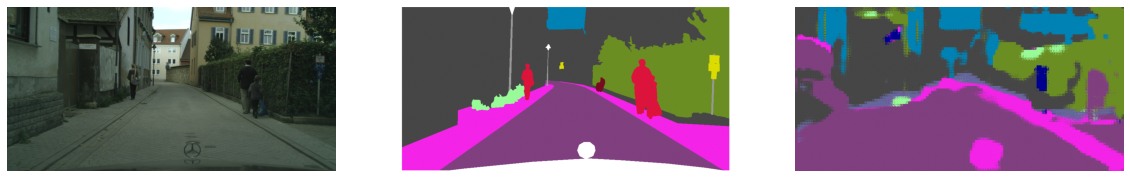

Client #33: 0.162 0.167 0.167 0.165 0.166 0.168 0.168 0.167 
Client #3: 0.182 0.183 0.185 0.182 0.184 0.184 0.184 0.183 
Client #25: 0.140 0.142 0.145 0.143 0.144 0.146 0.146 0.146 
Client #2: 0.157 0.156 0.154 0.155 0.153 0.157 0.156 0.155 
Client #19: 0.156 0.154 0.161 0.157 0.158 0.159 0.160 0.159 
Client #14: 0.143 0.139 0.144 0.139 0.143 0.143 0.141 0.142 
Client #10: 0.149 0.156 0.153 0.153 0.154 0.154 0.154 0.155 
Client #16: 0.145 0.141 0.144 0.144 0.146 0.142 0.149 0.143 
Client #23: 0.148 0.150 0.143 0.155 0.139 0.156 0.143 0.150 
Client #6: 0.150 0.153 0.153 0.153 0.155 0.155 0.155 

In [ ]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.half().to(DEVICE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_clients = train_dataset.get_num_clients()
print(f'Number of clients: {num_clients}')

server = Server(net, pseudo_lab=True)
server.load_model(MODEL_PATH)

clients = []
for i in range(num_clients):
    c = Client(i, train_dataset, net, pseudo_lab=True, num_epochs=NUM_EPOCHS, lr=LR, batch_size=BATCH_SIZE, 
               momentum=0.9, weight_decay=5e-5, device=DEVICE)
    c.criterion.set_teacher(deepcopy(server.model).half())
    clients.append(c)

for r in range(NUM_ROUNDS):
    server.select_clients(r, clients, num_clients=NUM_CLIENTS)
    server.train_model()
    server.update_model()
    miou = server.test_model(test_loader, DEVICE)
    print(f'ROUND {r+1}: server mIoU = {miou:.3f}')
    display_prediction(server.model, test_dataset, random=False)
server.plot_history()

In [ ]:
display_prediction(net, test_dataset, random=True)